In [1]:
%matplotlib inline
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]="0"
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import math
#limit the amount of allocated memory of each GPU by 30%
config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.3
#session = tf.Session(config=config)
session = tf.Session()


In [2]:
def autoencoder(dimension):
    x = tf.placeholder(tf.float32,[None,dimension[0]],name='x')
    current_in = x
    
    weights = []
    for out_size in dimension[1:]:
        in_size = int(current_in.get_shape()[1])
        
        w = tf.Variable(tf.random_uniform([in_size,out_size],-1/math.sqrt(in_size),1/math.sqrt(in_size)))
        #w = tf.Variable(tf.random_uniform([in_size,out_size],-0.05,0.05))
        #w = tf.Variable(tf.random_normal([in_size,out_size],0,1))
        #w = tf.Variable(tf.zeros([in_size,out_size]))
        b = tf.Variable(tf.zeros(out_size))
        
        weights.append(w)
        
        output = tf.nn.relu(tf.matmul(current_in,w)+b)
        current_in = output
    
    code = current_in
    
    weights.reverse()
    for i, out_size in enumerate(dimension[:-1][::-1]):
        w = tf.transpose(weights[i])
        b = tf.Variable(tf.zeros(out_size))
        
        output=tf.nn.relu(tf.matmul(current_in,w)+b)
        current_in=output
    
    y = current_in
    cost = tf.reduce_sum(tf.square(y-x))
    
    l1_regularizer = tf.contrib.layers.l1_regularizer(scale=0.05)
    regularization_penalty = tf.contrib.layers.apply_regularization(l1_regularizer, weights)
    
    cost+=regularization_penalty
    
    return {'x':x, 'code':code, 'y':y, 'cost':cost}   

In [3]:
from tensorflow.examples.tutorials.mnist import input_data
data = input_data.read_data_sets("data/MNIST/", one_hot=True)
data_mean=0#np.mean(data.train.images,axis=0)

Extracting data/MNIST/train-images-idx3-ubyte.gz
Extracting data/MNIST/train-labels-idx1-ubyte.gz
Extracting data/MNIST/t10k-images-idx3-ubyte.gz
Extracting data/MNIST/t10k-labels-idx1-ubyte.gz


In [4]:
learning_rate=[0.001]
cost={}
batch_size=100
epoch=50

for rate in learning_rate:
    cost[rate]=[]
    ae = autoencoder([784,1000,500,250,30])
    optimizer = tf.train.RMSPropOptimizer(rate).minimize(ae['cost'])
    session.run(tf.global_variables_initializer())
    
    for e in range(epoch):
        for b in range(data.train.num_examples // batch_size):
            x_batch, y_true = data.train.next_batch(batch_size)
            diff=np.array([img - data_mean for img in x_batch])
            session.run(optimizer,feed_dict={ae['x']:diff})
        #print(e, session.run(ae['cost'], feed_dict={ae['x']: diff}))
        cost[rate].append(session.run(ae['cost'], feed_dict={ae['x']: diff}))

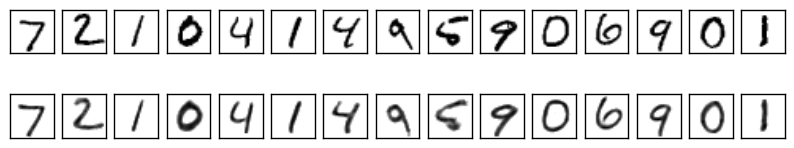

In [5]:
if True:
    n_examples = 15
    test_xs, _ = data.test.next_batch(n_examples)
    test_xs_norm = np.array([img - data_mean for img in test_xs])
    recon = session.run(ae['y'], feed_dict={ae['x']: test_xs_norm})
    fig, axs = plt.subplots(2, n_examples, figsize=(10, 2))

    for example_i in range(n_examples):
        axs[0][example_i].imshow(        
            test_xs[example_i].reshape(28, 28), cmap='binary')
        axs[1][example_i].imshow(
            #np.reshape([recon[example_i, :]+data_mean], (28, 28)), cmap='binary')
            (recon[example_i]+data_mean).reshape(28, 28), cmap='binary')
        axs[0][example_i].set_xticks([])
        axs[0][example_i].set_yticks([])
        axs[1][example_i].set_xticks([])
        axs[1][example_i].set_yticks([])

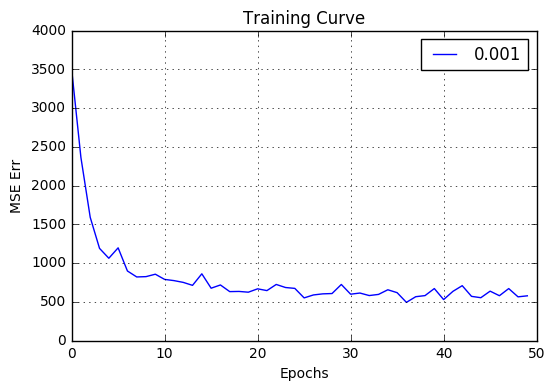

In [6]:
for rate in learning_rate:
    plt.plot(range(epoch),cost[rate],label=str(rate))
plt.grid()
plt.legend(loc='best')
plt.xlabel("Epochs")
plt.ylabel("MSE Err")
plt.title("Training Curve")

In [7]:
#plt.imshow((data.train.images[1]).reshape(28,28),cmap='binary')
#plt.imshow((data_mean).reshape(28,28),cmap='binary')
#plt.imshow((data.train.images[1]-data_mean).reshape(28,28),cmap='binary')
#data_mean.reshape(28,28)[5]
#(data.train.images[1]).reshape(28,28)[5]
#(data.train.images[1]-data_mean).reshape(28,28)[5]

In [8]:
#tf.train.Saver().save(session,"model/autoencoder.ckpt")